<h1>template notebook</h1>

import libraries

In [1]:
#defaul libraries
#https://docs.python.org/ja/
import os
import sys
import io

import math
import random
import pprint
import time
import datetime
import typing
import json
import glob
import requests
import warnings
import gc
from pprint import pprint
import re

import numpy as np #https://numpy.org/
import pandas as pd #https://pandas.pydata.org/
import sklearn #https://scikit-learn.org/stable/

import matplotlib.pyplot as plt #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
%matplotlib inline

import seaborn as sns
sns.set()

from tqdm import tqdm #https://tqdm.github.io/

import torch #https://pytorch.org/
import transformers #https://huggingface.co/transformers/

import torchvision
import torchtext

CFG

In [2]:
class CFG():
    
    data_path="/kaggle/input/digit-recognizer"
    debug=True
    seed=0

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    batch_size=1#32
    epochs=30
    learning_rate=0.1
    kFold=5


    #高速化関連
    #https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587

    #GPU 遅くなるらしい↓
    torch.backends.cudnn.deterministic = True

    #イテレーションごとのnnの順伝搬および誤差関数の 計算手法がある程度一定であれば、torch.backends.cudnn.benchmark = Trueで GPU での計算が高速化
    torch.backends.cudnn.benchmark = False


def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)

print(CFG.device)
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name())

cpu


color

In [3]:
def color(string,fg='DEFAULT',bg='DEFAULT',fg_rgb=None,bg_rgb=None,style='END'):
    colors=['BLACK','RED','GREEN','YELLOW','BLUE','PURPLE','CYAN','WHITE','8','DEFAULT']
    styles=['END','BOLD','2','3','UNDERLINE','5','6','REVERSE','INVISIBLE','9']

    fg=f'\033[3{colors.index(fg)}m'
    bg=f'\033[4{colors.index(bg)}m'
    style=f'\033[0{styles.index(style)}m'

    if fg_rgb:fg=f"\033[38;2;{fg_rgb[0]};{fg_rgb[1]};{fg_rgb[2]}m"
    if bg_rgb:bg=f"\033[48;2;{bg_rgb[0]};{bg_rgb[1]};{bg_rgb[2]}m"

    return style+fg+bg+str(string)+'\033[0m'

In [4]:
# %%script echo skipping

train=pd.read_csv(os.path.join(CFG.data_path,"train.csv"))
test=pd.read_csv(os.path.join(CFG.data_path,"test.csv"))
sample_submission=pd.read_csv(os.path.join(CFG.data_path,"sample_submission.csv"),index_col='ImageId')

# if CFG.debug:
#     #train=train[:len(train)//50]
#     train=train.sample(frac=0.1)

df=pd.concat([train,test])
# train=df[:len(train)].copy()
# test=df[len(train):].copy()

data={
    'train':train,
#     'val':pd.DataFrame({'feature':val.feature,'target':val['target']}),
    'test':test,
}

In [5]:
data['train']

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

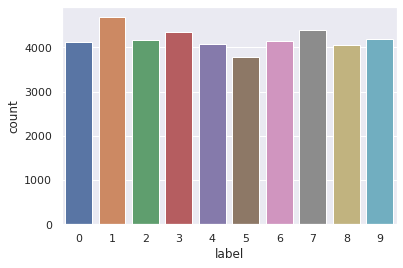

In [6]:
sns.countplot(train['label'])

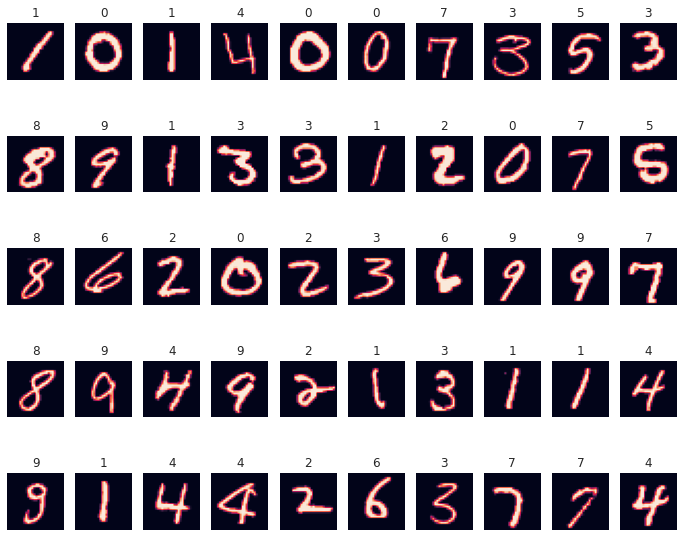

In [7]:
plt.figure(figsize=(12,10))
x, y = 10, 5 # 10列5行
for i in range(50):  
    plt.subplot(y, x, i+1)
    plt.imshow(np.array(data['train'].iloc[i,1:]).reshape((28,28)))
    plt.axis('off')
    plt.title(data['train'].iloc[i,0])
plt.show()

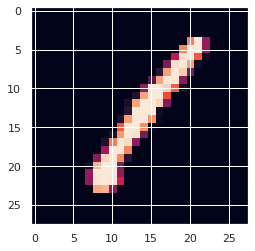

In [8]:
plt.imshow(np.array(data['train'].iloc[0,1:]).reshape(28,28))
plt.show()

100%|██████████| 42000/42000 [00:15<00:00, 2712.20it/s]


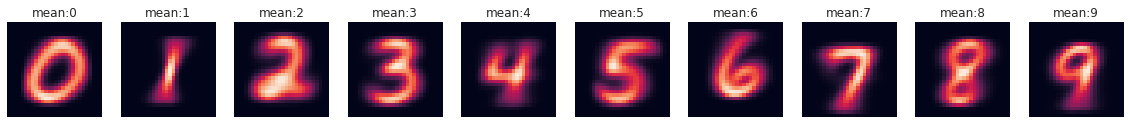

In [9]:
mean_digits=np.zeros((10,28*28))

for i in tqdm(range(len(data['train']))):
    mean_digits[data['train'].iloc[i,0]]+=data['train'].iloc[i,1:]
    
mean_digits/=len(data['train'])

plt.figure(figsize=(20,10))
for i in range(10):  
    plt.subplot(1, 10, i+1)
    plt.imshow(mean_digits[i].reshape((28,28)))
    plt.axis('off')
    plt.title(f'mean:{i}')
plt.show()

submission

In [10]:
submission=pd.DataFrame(index=sample_submission.index,columns=['Label'])
submission

,Label
ImageId,
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
27996,NaN
27997,NaN
27998,NaN


# sample_submission

In [11]:
submission.Label=[0]*len(submission)
submission
#0.09896
submission.to_csv("submission.csv",index=submission.index.name)

# PCA

In [12]:
def PCA(data,test,d,row=False):
    # d:写像する空間の次元
    
    if row:data=data.T#データを縦ベクトルに
    #print(train.shape) (dim,num)
    
    # 共分散行列:分散（bias=0）
    Sigma=np.cov(data,rowvar=1,bias=0)
    eigen_values, eigen_vectors = np.linalg.eig(Sigma)
    U=eigen_vectors[:,0:d]#固有値の大きい上位d個の固有ベクトル
    m=np.mean(data,axis=1)
    #2次元空間X_に射影
    data_=pd.DataFrame(np.zeros((d,data.shape[1])))
    for i in tqdm(range(1,data.shape[1])):
        data_.iloc[:,i]=U.T@(data.iloc[:,i]-m)
    if row:data_=data_.T

    if row:test=test.T
    test_=pd.DataFrame(np.zeros((d,test.shape[1])))
    for i in tqdm(range(1,test.shape[1])):
        test_.iloc[:,i]=U.T@(test.iloc[:,i]-m)
    if row:test_=test_.T
    return data_,test_

data_,test_=PCA(data['train'].drop('label',axis=1),data['test'],2,True)

100%|██████████| 27999/27999 [00:36<00:00, 763.83it/s]


/opt/conda/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1201: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
100%|██████████| 1000/1000 [00:05<00:00, 180.35it/s]


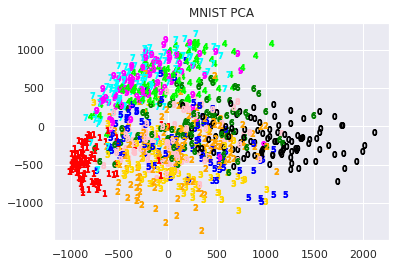

In [13]:
data_=data_.astype(int)
digit_color= {0:"black",1:"red",2:"orange",3:"gold",4:"lime",5:"blue",6:"green",7:"cyan",8:"pink",9:"magenta"}
plt.title("MNIST PCA")
for i in tqdm(range(1000)):
    plt.scatter(
        data_.iloc[i,0],
        data_.iloc[i,1],
        color=digit_color[data['train'].label.iloc[i]],
        marker="$"+str(data['train'].label.iloc[i])+"$"
    )
plt.show()

# SVM

In [14]:
%%time
from sklearn import svm

clf = svm.SVC(verbose=False)
clf.fit(data['train'].drop('label',axis=1),data['train']['label'])
submission.Label=clf.predict(data['test'])
submission
#0.97521
submission.to_csv("svm.csv",index=submission.index.name)

CPU times: user 11min 14s, sys: 425 ms, total: 11min 14s
Wall time: 11min 15s


# knn

In [15]:
def knn(k,data,test,label):
    ans=np.zeros(test.shape[0])
    
    for i in tqdm(range(test.shape[0])):
        distance=np.zeros(data.shape[1])
        
        for j in range(data.shape[1]):
            #euclidean_distance
            distance[j]=np.linalg.norm(test.iloc[i,:]-data.iloc[j,:])
            
        cnt=np.zeros(10)
        for K in range(k):
            cnt[int(label[np.argmin(distance)])]+=1
            distance[np.argmin(distance)]=10000000
        #print(cnt)
        ans[i]=np.argmax(cnt)
    return ans

In [16]:
%%time
# submission.Label=knn(1,data['train'].drop('label',axis=1),data['test'],data['train']['label'])
submission
#0.97014
#submission.to_csv("knn.csv",index=submission.index.name)

# time: 3h 5min

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


,Label
ImageId,
1,2
2,0
3,9
4,9
5,3
...,...
27996,9
27997,7
27998,3


In [17]:
%%time
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(data['train'].drop('label',axis=1),data['train']['label'])
submission.Label=clf.predict(data['test'])
submission
#0.97014
submission.to_csv("knn.csv",index=submission.index.name)

CPU times: user 34min 9s, sys: 810 ms, total: 34min 10s
Wall time: 34min 10s
